In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import basinhopping
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def lat_fit(data, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17):
    FZ = data[0]
    SA = data[1]
    IA = data[2]

    C = a0
    D = FZ * (a1 * FZ + a2) * (1 - a15 * IA**2)
    
    BCD = a3 * np.sin(np.arctan(FZ / a4) * 2) * (1 - a5 * abs(IA))
    B = BCD / (C * D)
    H = a8 * FZ + a9 + a10 * IA

    E = (a6 * FZ + a7) * (1 - (a16 * IA + a17) * np.sign(SA + H))

    V = a11 * FZ + a12 + (a13 * FZ + a14) * IA * FZ
    Bx1 = B * (SA + H)

    return D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V

In [21]:
def long_fit(data, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, IA_coeff_shift, IA_coeff_mult):
    FZ = data[0] / 1000 * -1
    SR = data[1]
    IA = data[2]

    C = b0
    D = FZ * (b1 * FZ + b2)
    
    BCD = (b3 * FZ**2 + b4 * FZ) * np.exp(-1 * b5 * FZ)
    B = BCD / (C * D)
    H = b9 * FZ + b10

    E = (b6 * FZ**2 + b7 * FZ + b8) * (1 - b13 * np.sign(SR + H))

    V = b11 * FZ + b12
    Bx1 = B * (SR + H)

    # return (D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V)

    # return (D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V) * (IA_coeff_shift)

    return (D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V) * (abs(IA) * IA_coeff_mult + IA_coeff_shift)

In [22]:
tires = {"hoosier_r25b_18x7-5_10x7":{"long":None, "lat":None}}

camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
run_num = 1

In [23]:
for name, tire in tires.items():
    try:
        df = pd.read_csv(f"../tire_data/processed_data/braking_{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["slip_a"] == slip_angle) & (df["camber"] == 4)]
        # print(tire["long"])

    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../tire_data/processed_data/cornering_{name}.csv")
        tire["lat"] = df[(df["velocity"] == velocity) & (df["pressure"] == pressure)]
        # print(tire["lat"])

    except:
        print("Error getting lateral data for {0}".format(name))

Error getting lateral data for hoosier_r25b_18x7-5_10x7


In [24]:
# optimal = [1.3327545282029503, 3998.0501866030863, 1095.574619300244, 202.73680550092124, 102.0132136391437, -2.1111400264904785, 0.0752231371687081, 1.2350909542556838, -2.9429274100378766, -0.11003080683875455, 0.08015513740846447, -0.05059463282937671, -0.8884485894267861, 0.3967627703123908, 0.6184528247140044, 0.09258091622115161]
optimal = [1.3327545282029503, 3998.0501866030863, 1095.574619300244, 202.73680550092124, 102.0132136391437, -2.1111400264904785, 0.0752231371687081, 1.2350909542556838, -2.9429274100378766, -0.11003080683875455, 0.08015513740846447, -0.05059463282937671, -0.8884485894267861, 0.3967627703123908, 0.6184528247140044, 0.09258091622115161]
df = tires[list(tires.keys())[0]]["long"]
x_lst = df["FZ"].tolist()
y_lst = [x * 100 for x in df["SL"].tolist()]
z_lst = df["IA"].tolist()

w_lst = df["FX"].tolist()

In [30]:
def accuracy(coeffs):
    ia_count = 0
    for i in range(2717):
        predicted = long_fit([x_lst[i], y_lst[i], z_lst[i]], *coeffs)
        
        if predicted == 0:
            error = (w_lst[i] - (predicted + 0.00001)) / (predicted + 0.00001) * 100
        else:
            error = (w_lst[i] - predicted) / predicted * 100
            
        if abs(error) >= 1:
            ia_count += 1

    return ((1 - ia_count / 2717) * 100)**-1 if ((1 - ia_count / 2717) * 100) > 0 else 0

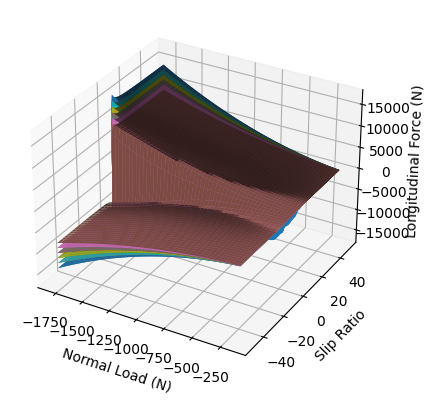

In [32]:
# params = basinhopping(accuracy, optimal, niter = 100).x
# print(list(params))

# params = optimal

model_x_data = np.linspace(-1800, max(x_lst), 1000)
model_y_data = np.linspace(-50, 50, 100)

X, Y = np.meshgrid(model_x_data, model_y_data)

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

ax = plt.axes(projection='3d')

# W_lst = long_fit([X, Y, 0], *params)

# ax.plot_surface(X, Y, W_lst)

fig.add_axes(ax)
for IA in np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]):
    W_lst = long_fit([X, Y, IA], *optimal)
    ax.plot_surface(X, Y, W_lst)

ax.scatter3D(x_lst, y_lst, w_lst, cmap='Greens')
ax.set_xlabel('Normal Load (N)')
ax.set_ylabel('Slip Ratio')
ax.set_zlabel('Longitudinal Force (N)')

plt.show()